Final Project Submission
</br>Please fill out:
</br>Student name: Dhruv Ragunathan
</br>Student pace: part time
</br>Scheduled project review date/time: 11/16/2024
</br>Instructor name: Mark Barbour
</br>Blog post URL:

# Background

Pneumonia is an infection that inflames the lungs from many potential vectors: Bacteria, Viruses, Fungi, etc. Pneumonia is a potentially fatal infection, that if not identified early on could put the patient's life at risk especially in acute-care settings.

Data sets off lungs with Pneumonia and healthy lungs were provided by Guangzhou Women and Children’s Medical Center, Guangzhou.


![image.png](Images/image.png)


Figure S6. Illustrative Examples of Chest X-Rays in Patients with Pneumonia, Related to Figure 6
The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.

The link to download the dataset is here. The dataset was downloaded from this link

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

# Business Objectives

The goal is to create a model that accurately predicts if an X-ray of a lung has pneumonia. The model will optimize on two metrics:

* Accuracy determines off the overall predictions how many were accurate. False positives in the context of this scenario mean that hospital staff will spend time checking with patients who don't have pneumonia. This could waste resources across the organization.
* Recall indicates how many patients were identified to have pneumonia across the overall population of patients that have pneumonia. Having a high recall means you are identifying a high percentage of the patients that have pneumonia. This could correlate into more lives saved.

The final model will be selected based on the accuracy and recall values. Recall will be prioritized over accuracy since saving lives is more important than limiting false positives.

The model will be deployed in a hospital where time is critical. Identifying someone who has pneumonia hours before complications occur can save lives.


# Data Exploration

Data contains 3 data sets, train, test, and validation. In each file, there are two folders: Pneumonia and normal. Images in the Pneumonia file are named depending on whether the source off the infection is bacterial or viral.

First separate them out based on whether they are normal or have pneumonia.

The images that contain pneumonia are divided based on whether the cause off the ailment was bacterial or viral. Since the purpose of the model is too determine whether Pneumonia is present, we will not distinguish or aim to predict the source off the pneumonia.

## Google Colab Code

This is the code ran on to import the files into google colab. It is commented out for convenience.

In [2]:
"""

from google.colab import drive
drive.mount('/content/gdrive')

"""

"\n\nfrom google.colab import drive\ndrive.mount('/content/gdrive')\n\n"

In [3]:
#%cd gdrive/My Drive/Pneumonia_Image_Detection/Pneumonia_Image_Detection

In [2]:
# Import data sets

import os, shutil
import time
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import numpy as np
import seaborn as sns
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn. metrics import recall_score, confusion_matrix
np.random.seed(42)

In [3]:
folders = {}
train = {}
test = {}
test = {}
val = {}

main_folder = "chest_xray"

train_folder = main_folder + "/train"
train_P = train_folder + "/PNEUMONIA"
train_N = train_folder + "/NORMAL"

test_folder = main_folder + "/test"
test_P = test_folder + "/PNEUMONIA"
test_N = test_folder + "/NORMAL"

val_folder = main_folder + "/val"
val_P = val_folder + "/PNEUMONIA"
val_N = val_folder + "/NORMAL"


pneu_folds = [train_P,test_P,val_P] #put all pneumonia file paths in one list

normal_folds = [train_N,test_N,val_N] #Put all normal file paths in one list

all_folds = [pneu_folds,normal_folds]




In [4]:
"""

The code below looks at all the file paths. It counts the number of images in each file path and determines
the total number of images with pneumonia or that are normal.

"""



total_normal = 0
total_pneumonia = 0

total_train_P = 0
total_train_N = 0

total_test_P = 0
total_test_N = 0

total_val_P = 0
total_val_N = 0

for folders in all_folds:

    for file_path in folders:

        folder = file_path.split("/") #Split the file path based on the /

        folder_name = folder[2] # Tells us if the folder is for PNEUMONIA or Normal Images
        folder_data = folder[1] # Tells us if the folder is for the training, testing, or val data

        if folder_name == 'PNEUMONIA':

            num_imgs = len([file for file in os.listdir(file_path) if file.endswith('.jpeg')])


            total_pneumonia = total_pneumonia + num_imgs

            if folder_data == 'train':

                total_train_P = num_imgs

            if folder_data == 'test':

                total_test_P = num_imgs


            if folder_data == 'val':

                total_val_P = num_imgs


        if folder_name == 'NORMAL':

            num_imgs = len([file for file in os.listdir(file_path) if file.endswith('.jpeg')])

            total_normal = total_normal + num_imgs

            if folder_data == 'train':

                total_train_N = num_imgs

            if folder_data == 'test':

                total_test_N = num_imgs


            if folder_data == 'val':

                total_val_N = num_imgs


total_images = total_pneumonia + total_normal




In [5]:
print('There are',total_images, 'images total')

print('There are',total_pneumonia, 'lungs with pneumonia')

print('There are',total_normal, 'lungs without pneumonia')

There are 5856 images total
There are 4273 lungs with pneumonia
There are 1583 lungs without pneumonia


In [6]:
total_train_P
total_train_N

total_test_P
total_test_N

total_val_P
total_val_N


print('In the train data set the split between pneumonia and normal lungs is ',total_train_P,' and ',total_train_N,' respectively.')
print('In the test data set the split between pneumonia and normal lungs is ',total_test_P,' and ',total_test_N,' respectively.')
print('In the validation data set the split between pneumonia and normal lungs is ',total_val_P,' and ',total_val_N,' respectively.')

In the train data set the split between pneumonia and normal lungs is  3875  and  1341  respectively.
In the test data set the split between pneumonia and normal lungs is  390  and  234  respectively.
In the validation data set the split between pneumonia and normal lungs is  8  and  8  respectively.


The split between the training, testing, and validation data is not ideal. The data in the validation dataset is miniscule (16) compared to the training and testing set (~5200 and ~600, respectively). Later we will combine the data before doing train-test splits.

<BarContainer object of 2 artists>

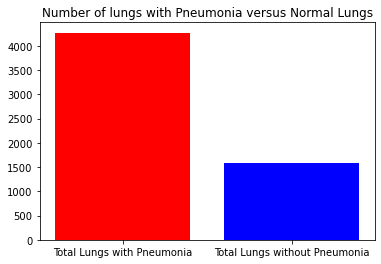

In [7]:
# Visualize total number of infected lungs versus uninfected

plt.title("Number of lungs with Pneumonia versus Normal Lungs")
plt.bar(["Total Lungs with Pneumonia", "Total Lungs without Pneumonia"], [total_pneumonia,total_normal], color = ["r","b"])

The number of lungs with pneumonia is nearly 3 times greater than the number of lungs without. This means that if a model predicted that every image had pneumonia on this data set, it would be accurate 75% of the time. This context is important when evaluating the models in the latter part of the notebook.

# Data Preparation

The Process to prepare the data was as follows:
1. First we used Image Data Generator on the images in the test, train, and val data.
2. Then we created the labels for the target variable. Whether an xray is for a patient with Pneumonia or not.
3. Due to the disparities between the given training, testing, and val set, all data was combined into one dataset.
4. Data then split into training and testing sets. Since Neural Networks are computationally expensive. Two train test splits were done too reduce the size. The final training data set contained nearly 2500 images.

In [8]:
# get all the data in the directory split/test (624 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder,
         batch_size = 624)

# get all the data in the directory split/validation (16 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder,
        batch_size = 16)

# get all the data in the directory split/train (5216 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder,
        batch_size=5216)

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [9]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [10]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (5216, 256, 256, 3)
train_labels shape: (5216, 2)
test_images shape: (624, 256, 256, 3)
test_labels shape: (624, 2)
val_images shape: (16, 256, 256, 3)
val_labels shape: (16, 2)


In [11]:
# combine three original datasets into one for data and labels
X = np.concatenate((train_images, test_images, val_images))
y_labels = np.concatenate((train_labels, test_labels, val_labels))

In [12]:
# total dataset size
X.shape

(5856, 256, 256, 3)

In [13]:
y = np.reshape(y_labels[:,0], (5856,1))

In [14]:
# Further Explore Dataset

m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (5216, 256, 256, 3)
train_labels shape: (5216, 2)
test_images shape: (624, 256, 256, 3)
test_labels shape: (624, 2)
val_images shape: (16, 256, 256, 3)
val_labels shape: (16, 2)


## Train - Test Data Split

Using the full training data is not ideal to iteratively determine model parameters. The complete training set takes around 30 minutes to run with straightforward parameters (i.e. one convulution layer, one pooling layer, and one dense layer).

The strategy here is too split the data set into a smaller chunk.

### Convolutional Neural Network Data Preparation

Now we need to do a train test split to the data formatted for the Convolutional Neural Network.

In [15]:
# First split the data into half.

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X,y, test_size= 0.5)

In [16]:
# Then split again by 15%

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_train_1, y_train_1, test_size= 0.15)

# Modeling

## First Convolution Neural Network

Base model is a simple convolution neural network. Contains one convolution layer, one pooling layer, and 10 neurons in the dense layer.

This model has achieved a ~95% accuracy on the training data set and a 93% accuracy on the testing data set. The training and testing recalls were 90% and 87%, respectively.

In [18]:
model_cnn_1 = models.Sequential()

# add convolutional and pooling layers
model_cnn_1.add(layers.Conv2D(8, (4, 4), activation='relu',
                        input_shape=(256 ,256,  3)))
model_cnn_1.add(layers.MaxPooling2D((2, 2)))

# flatten pooled featrue maps
model_cnn_1.add(layers.Flatten())

# add dense hidden layer and output
model_cnn_1.add(layers.Dense(10, activation='relu'))
model_cnn_1.add(layers.Dense(1, activation='sigmoid'))

In [19]:
# compile model
model_cnn_1.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy','Recall'])

In [20]:
# fit model to training data and validate
cnn_history_1 = model_cnn_1.fit(X_train_2,
                    y_train_2,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_test_2, y_test_2))

Epoch 1/30
78/78 [==============================] - 53s 683ms/step - loss: 0.5712 - accuracy: 0.7227 - recall: 0.0227 - val_loss: 0.5620 - val_accuracy: 0.6795 - val_recall: 0.0000e+00
Epoch 2/30
78/78 [==============================] - 57s 727ms/step - loss: 0.4322 - accuracy: 0.7424 - recall: 0.0393 - val_loss: 0.6147 - val_accuracy: 0.7068 - val_recall: 0.0851
Epoch 3/30
78/78 [==============================] - 48s 615ms/step - loss: 0.4022 - accuracy: 0.8075 - recall: 0.6888 - val_loss: 0.3597 - val_accuracy: 0.8682 - val_recall: 0.6170
Epoch 4/30
78/78 [==============================] - 39s 506ms/step - loss: 0.3612 - accuracy: 0.8637 - recall: 0.6994 - val_loss: 0.3894 - val_accuracy: 0.8909 - val_recall: 0.9574
Epoch 5/30
78/78 [==============================] - 39s 494ms/step - loss: 0.3291 - accuracy: 0.8855 - recall: 0.7508 - val_loss: 0.3229 - val_accuracy: 0.9136 - val_recall: 0.8227
Epoch 6/30
78/78 [==============================] - 39s 496ms/step - loss: 0.3162 - accurac

In [21]:
#model_cnn_1.save('Models/model_cnn_1.keras')

In [17]:
model_cnn_1 = models.load_model('Models/model_cnn_1.keras')

OSError: SavedModel file does not exist at: Models/model_cnn_1.keras/{saved_model.pbtxt|saved_model.pb}

In [23]:
conv_results_train_1 = model_cnn_1.evaluate(X_train_2, y_train_2)

78/78 [==============================] - 12s 155ms/step - loss: 0.1566 - accuracy: 0.9594 - recall: 0.9184


In [ ]:
conv_results_test_1 = model_cnn_1.evaluate(X_test_1, y_test_1)

In [ ]:
conv_results_test_2 = model_cnn_1.evaluate(X_test_2, y_test_2)

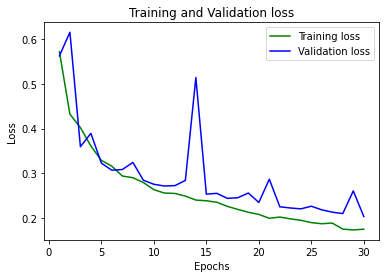

In [27]:
cnn_model_1_val_dict = cnn_history_1.history
loss_values1 = cnn_model_1_val_dict["loss"]
val_loss_values1= cnn_model_1_val_dict["val_loss"]

epochs = range(1,len(loss_values1) + 1)
plt.plot(epochs, loss_values1, "g", label="Training loss")
plt.plot(epochs, val_loss_values1, "blue", label="Validation loss")

plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

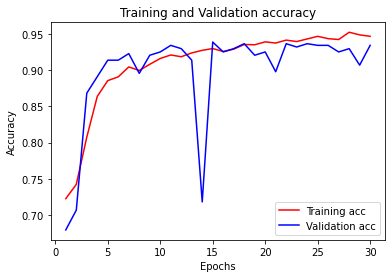

In [28]:
acc_values1 = cnn_model_1_val_dict["accuracy"]
val_acc_values1 = cnn_model_1_val_dict["val_accuracy"]

plt.plot(epochs, acc_values1, "r", label="Training acc")
plt.plot(epochs, val_acc_values1, "blue", label="Validation acc")

plt.title("Training and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

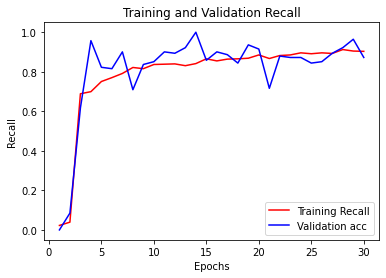

In [29]:
Recall_values1 = cnn_model_1_val_dict["recall"]
val_Recall_values1 = cnn_model_1_val_dict["val_recall"]

plt.plot(epochs, Recall_values1, "r", label="Training Recall")
plt.plot(epochs, val_Recall_values1, "blue", label="Validation acc")

plt.title("Training and Validation Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend()
plt.show()

These were the values of the model.

* Training Accuracy: 95%
* Testing Accuracy: 93%
* Training Recall: 90%
* Testing Recall: 87%

These are very good numbers for a baseline model. The training and testing accuracies are just a few percentage points off from one another. This does not imply significant overfitting. Let's see if we can improve on these numbers in the next iteration

## Second Colvolutional Neural Networks
* Add two more Convolutional Layers
* Increase Dense Layer to 30 neurons

Accuracy of training and testing data is 96%.

In [30]:
model_cnn_2 = models.Sequential()

# add 3 convolutional and pooling layers
model_cnn_2.add(layers.Conv2D(8, (4, 4), activation='relu',
                        input_shape=(256 ,256,  3)))
model_cnn_2.add(layers.MaxPooling2D((2, 2)))

# Second Convolutional Layer

model_cnn_2.add(layers.Conv2D(8, (4, 4), activation='relu',
                        input_shape=(256 ,256,  3)))
model_cnn_2.add(layers.MaxPooling2D((2, 2)))

#Third Convolutional Layer

model_cnn_2.add(layers.Conv2D(8, (4, 4), activation='relu',
                        input_shape=(256 ,256,  3)))
model_cnn_2.add(layers.MaxPooling2D((2, 2)))

# flatten pooled featrue maps
model_cnn_2.add(layers.Flatten())

# add dense hidden layer and output
model_cnn_2.add(layers.Dense(30, activation='relu'))
model_cnn_2.add(layers.Dense(1, activation='sigmoid'))

In [31]:
# compile model
model_cnn_2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy','Recall'])

In [32]:
# fit model to training data and validate
cnn_history_2 = model_cnn_2.fit(X_train_2,
                    y_train_2,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_test_2, y_test_2))

Epoch 1/30
78/78 [==============================] - 67s 855ms/step - loss: 0.5602 - accuracy: 0.7400 - recall: 0.0619 - val_loss: 0.5245 - val_accuracy: 0.6818 - val_recall: 0.0071
Epoch 2/30
78/78 [==============================] - 64s 818ms/step - loss: 0.4826 - accuracy: 0.7850 - recall: 0.3807 - val_loss: 0.7859 - val_accuracy: 0.3341 - val_recall: 1.0000
Epoch 3/30
78/78 [==============================] - 64s 815ms/step - loss: 0.4229 - accuracy: 0.8055 - recall: 0.5997 - val_loss: 0.3062 - val_accuracy: 0.8841 - val_recall: 0.7447
Epoch 4/30
78/78 [==============================] - 97s 1s/step - loss: 0.3198 - accuracy: 0.8617 - recall: 0.6798 - val_loss: 0.2549 - val_accuracy: 0.8795 - val_recall: 0.7234
Epoch 5/30
78/78 [==============================] - 67s 855ms/step - loss: 0.2705 - accuracy: 0.8895 - recall: 0.7749 - val_loss: 0.2281 - val_accuracy: 0.9023 - val_recall: 0.8723
Epoch 6/30
78/78 [==============================] - 67s 860ms/step - loss: 0.2564 - accuracy: 0.89

In [33]:
conv_results_train_2 = model_cnn_2.evaluate(X_train_2, y_train_2)

78/78 [==============================] - 28s 364ms/step - loss: 0.1425 - accuracy: 0.9449 - recall: 0.9471


In [34]:
conv_results_test_2 = model_cnn_2.evaluate(X_test_2, y_test_2)

14/14 [==============================] - 4s 318ms/step - loss: 0.1887 - accuracy: 0.9341 - recall: 0.9433


In [35]:
#model_cnn_2.save('Models/model_cnn_2.keras')

In [26]:
model_cnn_2 = tf.keras.models.load_model('/Models/to/model_cnn_2.keras')

OSError: SavedModel file does not exist at: /Models/to/model_cnn_2.keras/{saved_model.pbtxt|saved_model.pb}

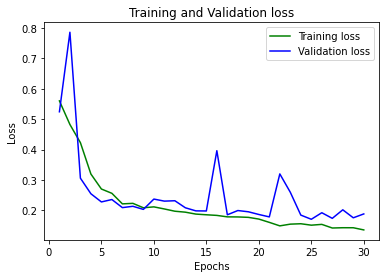

In [37]:
cnn_model_2_val_dict = cnn_history_2.history
loss_values2 = cnn_model_2_val_dict["loss"]
val_loss_values2= cnn_model_2_val_dict["val_loss"]

epochs = range(1,len(loss_values2) + 1)
plt.plot(epochs, loss_values2, "g", label="Training loss")
plt.plot(epochs, val_loss_values2, "blue", label="Validation loss")

plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Interestingly, increasing the dense layer and adding two convolution layers decreased the accuracy of the model on test data.

The training accuracy was 96% yet the testing accuracy was 93% and the recall was 85%. The recall significantly dropped from the previous model indicating that the model is not identifying as many pneumonia lungs.

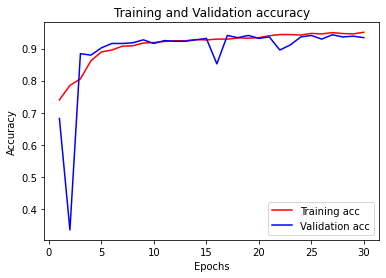

In [38]:
acc_values2 = cnn_model_2_val_dict["accuracy"]
val_acc_values2 = cnn_model_2_val_dict["val_accuracy"]

plt.plot(epochs, acc_values2, "r", label="Training acc")
plt.plot(epochs, val_acc_values2, "blue", label="Validation acc")

plt.title("Training and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

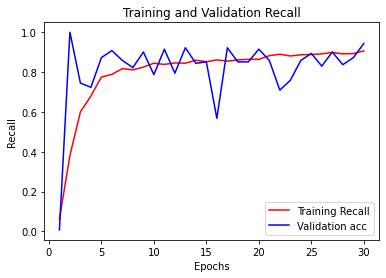

In [39]:
Recall_values2 = cnn_model_2_val_dict["recall"]
val_Recall_values2 = cnn_model_2_val_dict["val_recall"]

plt.plot(epochs, Recall_values2, "r", label="Training Recall")
plt.plot(epochs, val_Recall_values2, "blue", label="Validation acc")

plt.title("Training and Validation Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend()
plt.show()

These were the values of the model.

* Training Accuracy: 95%
* Testing Accuracy: 93%
* Training Recall: 91%
* Testing Recall: 87%

These are very good numbers for a baseline model. The training and testing accuracies are just a few percentage points off from one another. This does not imply significant overfitting. Let's see if we can improve on these numbers in the next iteration

## Third Convolution Neural Network

* Three Convolution layers
* Three Pooling layers
* 30 neurons in the dense layer
* Added a dropout parameter of 0.25

Adding a dropout rate did not significantly change the accuracy off the models. The training accuracy was 94% and the testing accuracy was 95%.

In [40]:
# First Convolutional Layer

model_cnn_3 = models.Sequential()
model_cnn_3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256 ,256,  3)))
model_cnn_3.add(layers.MaxPooling2D((2, 2)))
model_cnn_3.add(layers.Dropout(0.25))

# Second Convolutional Layer

model_cnn_3.add(layers.Conv2D(8, (4, 4), activation='relu',
                        input_shape=(256 ,256,  3)))
model_cnn_3.add(layers.MaxPooling2D((2, 2)))
model_cnn_3.add(layers.Dropout(0.25))


#Third Convolutional Layer

model_cnn_3.add(layers.Conv2D(8, (4, 4), activation='relu', input_shape=(256 ,256,  3)))
model_cnn_3.add(layers.MaxPooling2D((2, 2)))
model_cnn_3.add(layers.Dropout(0.25))


model_cnn_3.add(layers.Flatten())
model_cnn_3.add(layers.Dense(30, activation='relu'))
model_cnn_3.add(layers.Dropout(0.25))
model_cnn_3.add(layers.Dense(1, activation='sigmoid'))

model_cnn_3.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc','Recall'])



In [41]:
cnn_history_3 = model_cnn_3.fit(X_train_2,
                    y_train_2,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_test_2, y_test_2))

Epoch 1/30
78/78 [==============================] - 223s 3s/step - loss: 0.5766 - acc: 0.7303 - recall: 0.0332 - val_loss: 0.6201 - val_acc: 0.7023 - val_recall: 0.0709
Epoch 2/30
78/78 [==============================] - 218s 3s/step - loss: 0.4900 - acc: 0.7625 - recall: 0.2659 - val_loss: 0.4912 - val_acc: 0.8159 - val_recall: 0.4326
Epoch 3/30
78/78 [==============================] - 227s 3s/step - loss: 0.3908 - acc: 0.8356 - recall: 0.5755 - val_loss: 0.3729 - val_acc: 0.8750 - val_recall: 0.6667
Epoch 4/30
78/78 [==============================] - 249s 3s/step - loss: 0.3297 - acc: 0.8585 - recall: 0.6888 - val_loss: 0.3560 - val_acc: 0.9000 - val_recall: 0.8723
Epoch 5/30
78/78 [==============================] - 256s 3s/step - loss: 0.2840 - acc: 0.8903 - recall: 0.7674 - val_loss: 0.2937 - val_acc: 0.9068 - val_recall: 0.7518
Epoch 6/30
78/78 [==============================] - 252s 3s/step - loss: 0.2714 - acc: 0.8927 - recall: 0.7689 - val_loss: 0.2885 - val_acc: 0.9114 - val_r

In [42]:
#model_cnn_3.save('Models/model_cnn_3.keras')

In [43]:
#model_cnn_3 = models.load_model('Models/model_cnn_3.keras')

In [44]:
conv_results_train_3 = model_cnn_3.evaluate(X_train_2, y_train_2)

78/78 [==============================] - 31s 397ms/step - loss: 0.1448 - acc: 0.9453 - recall: 0.8776


In [45]:
conv_results_test_3 = model_cnn_3.evaluate(X_test_2, y_test_2)

14/14 [==============================] - 5s 367ms/step - loss: 0.1792 - acc: 0.9227 - recall: 0.8440


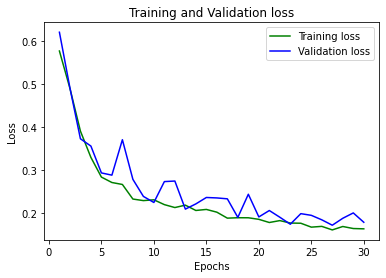

In [46]:
cnn_model_3_val_dict = cnn_history_3.history
loss_values3 = cnn_model_3_val_dict["loss"]
val_loss_values3= cnn_model_3_val_dict["val_loss"]

epochs = range(1,len(loss_values3) + 1)
plt.plot(epochs, loss_values3, "g", label="Training loss")
plt.plot(epochs, val_loss_values3, "blue", label="Validation loss")

plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

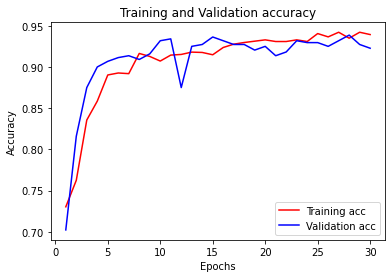

In [47]:
acc_values3 = cnn_model_3_val_dict["acc"]
val_acc_values3 = cnn_model_3_val_dict["val_acc"]

plt.plot(epochs, acc_values3, "r", label="Training acc")
plt.plot(epochs, val_acc_values3, "blue", label="Validation acc")

plt.title("Training and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

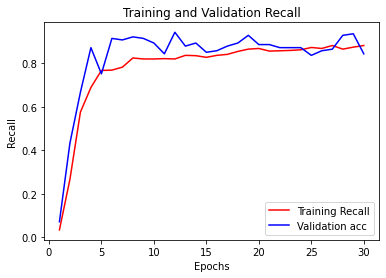

In [48]:
Recall_values3 = cnn_model_3_val_dict["recall"]
val_Recall_values3 = cnn_model_3_val_dict["val_recall"]

plt.plot(epochs, Recall_values3, "r", label="Training Recall")
plt.plot(epochs, val_Recall_values3, "blue", label="Validation acc")

plt.title("Training and Validation Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend()
plt.show()

Adding a dropout rate did not significantly change the accuracy off the models. The training accuracy was 94% and the testing accuracy was 95%. The recall was 89%. Slightly higher than the past two iterations.

## Fourth Convolution Neural Network

* Three Convolution layers
* Three Pooling layers
* 30 neurons in the dense layer
* Added a dropout parameter of 0.25
* L2 regularizer off 0.001 added

Training Accuracy is 93%, testing accuracy is 93%, and a recall of 92%. The training accuracy dropped somewhat.

In [49]:
# First Convolutional Layer

model_cnn_4 = models.Sequential()
model_cnn_4.add(layers.Conv2D(32, (3, 3), activation='relu',
                        kernel_regularizer=keras.regularizers.l2(l=0.001),input_shape=(256 ,256,  3)))
model_cnn_4.add(layers.MaxPooling2D((2, 2)))
model_cnn_4.add(layers.Dropout(0.25))

# Second Convolutional Layer

model_cnn_4.add(layers.Conv2D(8, (4, 4), activation='relu',
                              kernel_regularizer=keras.regularizers.l2(l=0.001),
                        input_shape=(256 ,256,  3)))
model_cnn_4.add(layers.MaxPooling2D((2, 2)))
model_cnn_4.add(layers.Dropout(0.25))


#Third Convolutional Layer

model_cnn_4.add(layers.Conv2D(8, (4, 4), activation='relu',
                              kernel_regularizer=keras.regularizers.l2(l=0.001),
                              input_shape=(256 ,256,  3)))
model_cnn_4.add(layers.MaxPooling2D((2, 2)))
model_cnn_4.add(layers.Dropout(0.25))

model_cnn_4.add(layers.Flatten())
model_cnn_4.add(layers.Dense(30, activation='relu'))
model_cnn_4.add(layers.Dropout(0.25))
model_cnn_4.add(layers.Dense(1, activation='sigmoid'))

model_cnn_4.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc','Recall'])



In [ ]:
cnn_history_4 = model_cnn_4.fit(X_train_2,
                    y_train_2,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_test_2, y_test_2))

Epoch 1/30
78/78 [==============================] - 152s 2s/step - loss: 0.5942 - acc: 0.7335 - recall: 0.0574 - val_loss: 0.6105 - val_acc: 0.7614 - val_recall: 0.2766
Epoch 2/30
78/78 [==============================] - 151s 2s/step - loss: 0.5082 - acc: 0.7749 - recall: 0.3082 - val_loss: 0.5987 - val_acc: 0.8045 - val_recall: 0.9291
Epoch 3/30
78/78 [==============================] - 158s 2s/step - loss: 0.4020 - acc: 0.8364 - recall: 0.5846 - val_loss: 0.3678 - val_acc: 0.8841 - val_recall: 0.7872
Epoch 4/30
78/78 [==============================] - 152s 2s/step - loss: 0.3404 - acc: 0.8694 - recall: 0.7251 - val_loss: 0.4147 - val_acc: 0.9227 - val_recall: 0.9149
Epoch 5/30
78/78 [==============================] - 149s 2s/step - loss: 0.3114 - acc: 0.8955 - recall: 0.7719 - val_loss: 0.3335 - val_acc: 0.9250 - val_recall: 0.8794
Epoch 6/30
78/78 [==============================] - 154s 2s/step - loss: 0.2984 - acc: 0.8947 - recall: 0.7840 - val_loss: 0.5456 - val_acc: 0.8091 - val_r

In [4]:
from lime import lime_image

ModuleNotFoundError: No module named 'lime'

In [ ]:
#model_cnn_4.save('Models/model_cnn_4_recall.keras')

In [29]:
#model_cnn_4 = models.load_model('Models/model_cnn_4_recall.keras')

OSError: SavedModel file does not exist at: Models/model_cnn_4_recall.keras/{saved_model.pbtxt|saved_model.pb}

In [ ]:
conv_results_test_4 = model_cnn_4.evaluate(X_test_2, y_test_2)

In [ ]:
cnn_model_4_val_dict = cnn_history_4.history
loss_values4 = cnn_model_4_val_dict["loss"]
val_loss_values4= cnn_model_4_val_dict["val_loss"]

epochs = range(1,len(loss_values4) + 1)
plt.plot(epochs, loss_values4, "g", label="Training loss")
plt.plot(epochs, val_loss_values4, "blue", label="Validation loss")

plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
acc_values4 = cnn_model_4_val_dict["acc"]
val_acc_values4 = cnn_model_4_val_dict["val_acc"]

plt.plot(epochs, acc_values4, "r", label="Training acc")
plt.plot(epochs, val_acc_values4, "blue", label="Validation acc")

plt.title("Training and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
Recall_values4 = cnn_model_4_val_dict["recall"]
val_Recall_values4 = cnn_model_4_val_dict["val_recall"]

plt.plot(epochs, Recall_values4, "r", label="Training Recall")
plt.plot(epochs, val_Recall_values4, "blue", label="Validation acc")

plt.title("Training and Validation Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend()
plt.show()

# Model Evaluation

We've run 4 models. All have had very good accuracy (over 93%) on both the training and testing data. Let's run these models over the the larger testing data set that was split off earlier.

In [ ]:
# Run CNN #1

CNN_Results_1 = model_cnn_1.evaluate(X_test_1,y_test_1)

CNN_Results_1

In [ ]:
# Run CNN #2

CNN_Results_2 = model_cnn_2.evaluate(X_test_1,y_test_1)

CNN_Results_2

In [ ]:
# Run CNN #3 Model

CNN_Results_3 = model_cnn_3.evaluate(X_test_1,y_test_1)

CNN_Results_3


In [ ]:
#Run CNN #4 Model

CNN_Results_4 = model_cnn_4.evaluate(X_test_1,y_test_1)

CNN_Results_4


In [ ]:
Models_Accuracy = [CNN_Results_1[1],CNN_Results_2[1],CNN_Results_3[1],CNN_Results_4[1],]

Models_Accuracy

In [ ]:
sns.lineplot(x = ["CNN - 1","CNN 2","CNN 3", "CNN 4"],y = Models_Accuracy)

plt.title("Accuracy of Neural Network Models")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# Do the same for recall

Models_Recall = [CNN_Results_1[2],CNN_Results_2[2],CNN_Results_3[2],CNN_Results_4[2],]

Models_Recall

In [ ]:
sns.lineplot(x = ["CNN - 1","CNN 2","CNN 3", "CNN 4"],y = Models_Recall)

plt.title("Recall of Neural Network Models")
plt.xlabel("Model")
plt.ylabel("Recall")
plt.show()

### Review of neural networks implemented above

* Base Neural Netork: No convolution. 3 layers.
* CNN 1: One Convolution layer
* CNN 2: Three Convolution Layers
* CNN 3: Dropout of 0.25 added
* CNN 4: Regularizer added

# Final Model Evaluation

Based on the accuracies above, the first neural network with one convolution layers and no regularizers or drop out had the highest accuracy.

Ultimately, all models had accuracies within a  percentage point from one - another. It would not be surprising if one of the models with regularization performed better on a different data set with significantly more records since the regularizers make it less likely for them to be overfit on the training data.

As stated above, the decision to pick a final model will be based on the accuracy and recall parameters, with recall being the priority. Even though model 4 has the lowest accuracy, it is the final selection because it has the highest recall. It's accuracy is only lower than the first model by around 1%. Yet it's recall is 3% higher than the rest of the models on the larger training data set. Higher recall could imply more lives saved.

In addition, here is also some further evidence supporting model 4 being the best. In the analysis below, we determined the variability of the accuracy values in the last 5 and 10 epochs. Model 4 had one of the lower variabilities when reviewing the plots off the accuracy/loss over the epochs. While model 3's was technically the lowest, model 4 was next.

We choose model 4 as our model because it has a higher recall than all models, ranked second in terms off having less variability, and had a similar accuracy to the other models.

In [ ]:
# First get the Last 10 values of the validation accuracy and store them in an array

cnn_1_acc_last_10 = cnn_model_1_val_dict["val_accuracy"][20:]

cnn_2_acc_last_10 = cnn_model_2_val_dict["val_accuracy"][20:]

cnn_3_acc_last_10 = cnn_model_3_val_dict["val_acc"][20:]

cnn_4_acc_last_10 = cnn_model_4_val_dict["val_acc"][20:]


# Get the standard deviation off those values

cnn_1_acc_std = np.std(cnn_1_acc_last_10)

cnn_2_acc_std = np.std(cnn_2_acc_last_10)

cnn_3_acc_std = np.std(cnn_3_acc_last_10)

cnn_4_acc_std = np.std(cnn_4_acc_last_10)


In [ ]:
Models_Std_lst_10 = [cnn_1_acc_std,cnn_2_acc_std,cnn_3_acc_std,cnn_4_acc_std]

sns.lineplot(x = ["CNN - 1","CNN 2","CNN 3", "CNN 4"],y = Models_Std_lst_10)

plt.title("Standard Deviation in Validation Accuracy During the Last 10 Epochs of Neural Network Models")
plt.xlabel("Model")
plt.ylabel("Validation Accuracy Standard Deviation")
plt.show()

## Charting the Standard Deviation in Accuracy during the Last 5 Epochs

In [ ]:
# First get the Last 5 values of the validation accuracy and store them in an array

cnn_1_acc_last_5 = cnn_model_1_val_dict["val_accuracy"][25:]

cnn_2_acc_last_5 = cnn_model_2_val_dict["val_accuracy"][25:]

cnn_3_acc_last_5 = cnn_model_3_val_dict["val_acc"][25:]

cnn_4_acc_last_5 = cnn_model_4_val_dict["val_acc"][25:]


# Get the standard deviation off those values

cnn_1_acc_std_5 = np.std(cnn_1_acc_last_5)

cnn_2_acc_std_5 = np.std(cnn_2_acc_last_5)

cnn_3_acc_std_5 = np.std(cnn_3_acc_last_5)

cnn_4_acc_std_5 = np.std(cnn_4_acc_last_5)


In [ ]:
Models_Std_lst_5 = [cnn_1_acc_std_5,cnn_2_acc_std_5,cnn_3_acc_std_5,cnn_4_acc_std_5]

sns.lineplot(x = ["CNN - 1","CNN 2","CNN 3", "CNN 4"],y = Models_Std_lst_5)

plt.title("Standard Deviation in Validation Accuracy During the Last 5 Epochs of Neural Network Models")
plt.xlabel("Model")
plt.ylabel("Validation Accuracy Standard Deviation")
plt.show()

In [ ]:
for i in range(0,4):
    print((Models_Std_lst_10[i]-Models_Std_lst_5[i])/(Models_Std_lst_10[i]))

The Standard Deviation in the accuracy decreased for CNN models 1. It remained roughly the same in model 3, but increased in Models 2 and 4. Indicating that the models were getting more stable in their predictions. For CNN Model 2, the standard deviation increased instead.

Even though CNN model 2 had the highest accuracy, because it showed a high variance in accuracy during the epochs it will not be the final model selected.

Let's look at some of the parameters in the selected model.

In [ ]:
model_cnn_4.summary()

The final model is a convolutional neural network model. It consists of 3 convolutional layers, 3 pooling layers, a flattening layer, and two final dense layers. The convolutional layers have filters of size (3,3). The first layer has 32 filters, followed by 8 filters in the second.

Each layer has a dropout for regularization.

Max pooling is done with a (2,2) dimension. The first dense layer contains 30 neurons, and the output layer contains one neuron with a sigmoid activation function. The final model has a 94.5% accuracy.



# Feature Analysis

Let's look at the features and the parts of the image our model emphasized to determine if a lung was pneumatic. Given the amount of data in an image, we will show images of lungs from the data set and highlight the portions that were activated by the model.

In [ ]:
from keras.preprocessing import image

img_path = 'chest_xray/train/NORMAL/IM-0115-0001.jpeg'


img = image.load_img(img_path, target_size=(256, 256))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

#Follow the Original Model Preprocessing
img_tensor /= 255.

#Check tensor shape
print(img_tensor.shape)

#Preview an image
plt.imshow(img_tensor[0])
plt.show()

In [ ]:
bacteria_img_path = 'chest_xray/test/PNEUMONIA/person82_bacteria_402.jpeg'
virus_img_path = 'chest_xray/test/PNEUMONIA/person11_virus_38.jpeg'
normal_img_path = 'chest_xray/train/NORMAL/IM-0115-0001.jpeg'

#Create tensor for normal Image
normal_img = image.load_img(normal_img_path, target_size=(256, 256))
normal_img_tensor = image.img_to_array(normal_img)
normal_img_tensor = np.expand_dims(normal_img_tensor, axis=0)

#Create tensor for bacterial pneumonia image
bacteria_img = image.load_img(bacteria_img_path, target_size=(256, 256))
bacteria_img_tensor = image.img_to_array(bacteria_img)
bacteria_img_tensor = np.expand_dims(bacteria_img_tensor, axis=0)

#Create tensor for viral pneumonia image
virus_img = image.load_img(virus_img_path, target_size=(256, 256))
virus_img_tensor = image.img_to_array(virus_img)
virus_img_tensor = np.expand_dims(virus_img_tensor, axis=0)


#Follow the Original Model Preprocessing
normal_img_tensor /= 255.
bacteria_img_tensor /=255.
virus_img_tensor /=255.

#Check tensor shape
print(normal_img_tensor.shape)
print(bacteria_img_tensor.shape)
print(virus_img_tensor.shape)

#Preview an image
print("Normal Lung")
plt.imshow(normal_img_tensor[0])
plt.show()

print("Bacterial Pneumonia Lung")
plt.imshow(bacteria_img_tensor[0])
plt.show()

print("Viral Pneumonia Lung")
plt.imshow(virus_img_tensor[0])
plt.show()

In [ ]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in model_cnn_4.layers[:8]]

# Display the models feature maps
activation_model = models.Model(inputs=model_cnn_4.input, outputs=layer_outputs)

In [ ]:
# Returns an array for each activation layer on the bacteria image
bacterial_activations = activation_model.predict(bacteria_img_tensor)

In [ ]:
fig, axes = plt.subplots(8, 4, figsize=(15,30))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    bacterial_first_layer_activation = bacterial_activations[0]
    ax.matshow(bacterial_first_layer_activation[0, :, :, i], cmap='viridis')

The above images display the feature maps generated by each convolutional layer. These maps identify unique patterns.

In [ ]:
# Returns an array for each activation layer on the virus image
viral_activations = activation_model.predict(virus_img_tensor)

In [ ]:
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    viral_first_layer_activation = viral_activations[0]
    ax.matshow(viral_first_layer_activation[0, :, :, i], cmap='viridis')

## Conclusions/Recommendations

* Recommend that you move forward with using the final model identified in the study since the model was 94% accurate in it’s prediction and identified 92% off the patients.
* Further research on how to operationalize this model in hospital workflows. Examples:
* How are false positives and negatives handled in a hospital? 
  * Is there a method for clinicians to quickly determine that the patient does not have pneumonia?
* Training on larger and more diverse data sets are needed before the model is used on patients over 5 years old.

# Future Projects



*   Train the model on x-rays in other age groups. Currently, the data is restricted to the under 5 age group. Increase to adults.
*   Train the model on other pathogens that can cause pneumonia such as fungi.
* Enhance the model to predict the source off pneumonia (i.e. bacteria, virus, or fungi). This could allow clinicians to administer the appropriate medicines faster.

